#  Cigar data anaylisis

In [1]:
# S2 signal script
import sys
sys.path.append('/home/investigator/mariandbt/python/notebooks/modules')
sys.path.append('/scratch/marian/python/notebooks/modules')

from datetime import datetime
import matplotlib.dates as mdates  # Import for date formatting
from matplotlib.ticker import ScalarFormatter

from import_modules import *
import set_up as setup
import s2_simulation as s2sim

from scipy.optimize import curve_fit

import glob
import re

##  Functions

In [2]:

CHAmp={
"CH1":535,
"CH2":537,
"CH3":684,
"CH4":675}

temp = 'room'

if temp == 'room':
    # Samuele's (20241025) RoomTemp
    ConvPar={
    "CH1":(2.75e-8,-6.32e-9), # V*s
    "CH2":(3.18e-8,-5.60e-9), # V*s
    "CH3":(3.58e-8,-3.49e-9), # V*s
    "CH4":(3.87e-8,-4.68e-9)  # V*s
    }

if temp == '14deg':
    # Marian's (20241022) 14deg
    ConvPar={
    "CH1":(3.26e-8,-7.32e-9), # V*s
    "CH2":(3.79e-8,-1.06e-8), # V*s
    "CH3":(4.44e-8,-1.03e-8), # V*s
    "CH4":(4.13e-8,-1.07e-8)  # V*s
    }

def ChargeToPes(integral, p0, p1):
    
#     integral is in V*us
    
    photoelectrons = (integral*1e-6 - p1) / p0
    return photoelectrons

# charge_in_pes = ChargeToPes(charge_in_Vus[f'CH{ii}']*CHAmp[f'CH{ii}'], *ConvPar[f'CH{ii}'])

In [3]:
# Sort the files based on the number that appears right before the '.h5' extension
def extract_number_h5(file):
    # Extract the number before '.h5' using regex
    match = re.search(r'_(\d+)\.h5$', file)  # Matches '_number.h5'
    return int(match.group(1)) if match else float('inf')  # Extract the number or return 'inf'


In [4]:
def ResponseSiPM(t, q_in_pes, t0, rise_time, decay_time, baseline = 0):

    """
    NOTE: units of t, t0, rise_time and decay_time must be the same
    """
    rise_term   = 1 - np.exp(-(t - t0) / rise_time)
    decay_term  = np.exp(-(t - t0) / decay_time)

    signal          = (rise_term * decay_term)
    signal[t<t0]    = 0
    signal          = signal + baseline
    signal_area     = np.trapz(x = t, y = signal) or 1

    normalized_signal = q_in_pes*signal/signal_area

    return normalized_signal 

In [5]:
def double_exponential(t, tau1, A1, tau2, A2):
    
    double_exp = np.zeros_like(t)
    
    exp1 = np.exp(-t[t>0]/tau1)
    exp2 = np.exp(-t[t>0]/tau2)
    
    double_exp[t>0] = (A1*exp1 + A2*exp2)
    
    return double_exp
    

In [6]:
def convolution_model(t, A, t0, rise, tau, tau1, A1, tau2, A2):
    """Convolution between s2sim.ResponseSiPM and a Gaussian."""
    dt = t[1] - t[0]  # Assuming uniform spacing in t
    
    response = ResponseSiPM(t, A, t0, rise, tau)
    
    double_exp = double_exponential(t, tau1, A1, tau2, A2)
    
    # Perform convolution
    convolved = np.convolve(response, double_exp, mode='same')*dt
    return convolved

def fit_function(t, A, t0, rise, tau, tau1, A1, tau2, A2):
    """Function to fit to the data."""
    return convolution_model(t, A, t0, rise, tau, tau1, A1, tau2, A2)

In [7]:
# Define helper function to shift and interpolate each row
def ShiftWaveformToPeak(row, t):
    peak_idx = np.argmax(row)        # Find the peak index for this row
    t_peak = t[peak_idx]             # Corresponding x-value of the peak
    t_shifted = t - t_peak           # Shift x-values so peak is at x=0
    # Interpolate the row onto the shifted x-axis, filling with boundary values
    aligned_row = np.interp(t, t_shifted, row, left=row[0], right=row[-1])
    return aligned_row

# Apply the helper function to each row
# aligned_y = np.apply_along_axis(shift_and_interpolate, 1, ch, t)

##  Data reading

In [8]:
# path = '/home/investigator/mariandbt/python/data'
path = '/scratch/marian/python/data'
path = path + '/cigar'

###  Mean waveform

In [9]:
runs = {
#         1.5: '20241011_with_am_1.5bar_N_14.0deg_no_amp', # only CH1
#         2.5: '20241011_with_am_2.5bar_N_14.0deg_no_amp', 
#         3.5: '20241011_with_am_3.5bar_N_14.0deg_no_amp', 
#         4.5: '20241016_with_am_4.5bar_N_14.0deg_no_amp', 
#         5.5: '20241018_with_am_5.5bar_Ar_14.0deg_no_amp', # only CH1
#         6.5: '20241021_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_14.0deg_no_amp', 
#         6.5: '20241022_with_am_6.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241023_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         7.5: '20241024_with_am_7.5bar_Ar_roomtemp_no_amp', 
#         8.2: '20241028_with_am_8.2bar_Ar_roomtemp_no_amp', 
#         8.5: '20241025_with_am_8.5bar_Ar_roomtemp_no_amp',
        8.5: '20241029_with_am_inside_8.5bar_Ar_roomtemp_no_amp',
        7.5: '20241030_with_am_inside_7.5bar_Ar_roomtemp_no_amp',
        6.5: '20241031_with_am_inside_6.5bar_Ar_roomtemp_no_amp',
        5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp',
#         5.5: '20241104_with_am_inside_5.5bar_Ar_roomtemp_no_amp_run2', # Hot getter mostly off 
        4.5: '20241105_with_am_inside_4.5bar_Ar_roomtemp_no_amp',
        3.5: '20241106_with_am_inside_3.5bar_Ar_roomtemp_no_amp',
        2.5: '20241107_with_am_inside_2.5bar_Ar_roomtemp_no_amp',
        1.5: '20241108_with_am_inside_1.5bar_Ar_roomtemp_no_amp',
        1.0: '20241111_with_am_inside_1.0bar_Ar_roomtemp_no_amp'
       }

In [10]:
bars     = 1.5
run      = runs[bars]
run_path = os.path.join(path, run) 

# Use glob to find all .h5 files in the directory
h5_files = glob.glob(f"{run_path}/*.h5")
h5_files = sorted(h5_files, key=extract_number_h5)

In [14]:
ch1s = []
ch2s = []
ch3s = []
ch4s = []

time_ticks = 6250



for file in h5_files[-5:-1]:
    
    print(f'Processing... {file}' + ' '*20, end = '\r')
    
    df = pd.read_hdf(file)
    
    t    = df["TIME"].to_numpy()[:time_ticks]
    ch1  = df["CH1"].to_numpy().reshape(-1, time_ticks)
    ch2  = df["CH2"].to_numpy().reshape(-1, time_ticks)
    ch3  = df["CH3"].to_numpy().reshape(-1, time_ticks)
    ch4  = df["CH4"].to_numpy().reshape(-1, time_ticks)
    
    ch1 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch1, t)    
    ch2 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch2, t)    
    ch3 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch3, t)    
    ch4 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch4, t)    
    
    # Peak correction
    for ch in [ch1, ch2, ch3, ch4]:
        inf_mask = np.isinf(ch)
        neg_inf_mask = np.isneginf(ch)
        
        ch[inf_mask] = ch[np.isfinite(ch)].max()
        ch[neg_inf_mask] = ch[np.isfinite(ch)].min()
    
    ch1_mean = np.average(ch1,axis=0)
    ch2_mean = np.average(ch2,axis=0)
    ch3_mean = np.average(ch3,axis=0)
    ch4_mean = np.average(ch4,axis=0)
    
    ch1s.append(ch1_mean)
    ch2s.append(ch2_mean)
    ch3s.append(ch3_mean)
    ch4s.append(ch4_mean)
    

ch1s = np.average(np.array(ch1s),axis=0)
ch2s = np.average(np.array(ch2s),axis=0)
ch3s = np.average(np.array(ch3s),axis=0)
ch4s = np.average(np.array(ch4s),axis=0)

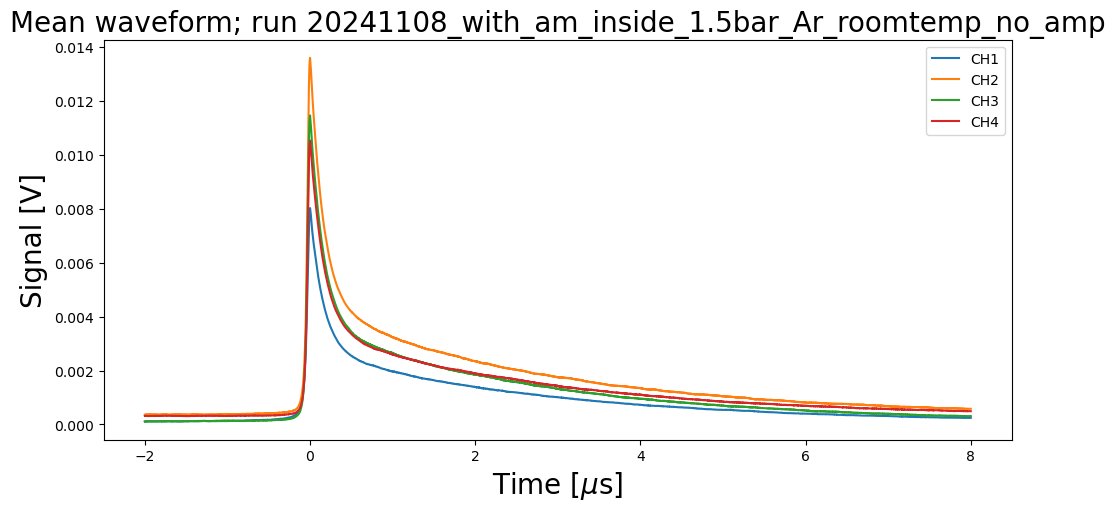

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

for i, ch in enumerate([ch1s, ch2s, ch3s, ch4s]):

    ax.plot(t*1e6, ch, label = f'CH{i+1}')

title = f'Mean waveform'

ax.set_title(f'{title}; run {run}', fontsize = font_size);
ax.set_xlabel(r'Time [$\mu$s]', fontsize = font_size);
ax.set_ylabel('Signal [V]', fontsize = font_size);

ax.legend()
# ax.set_xlim(0, 2)

In [13]:
df_area = np.trapz(x = t, y = ch1s)


In [14]:
df_area

7.914696878520832e-09

###  Exp fit

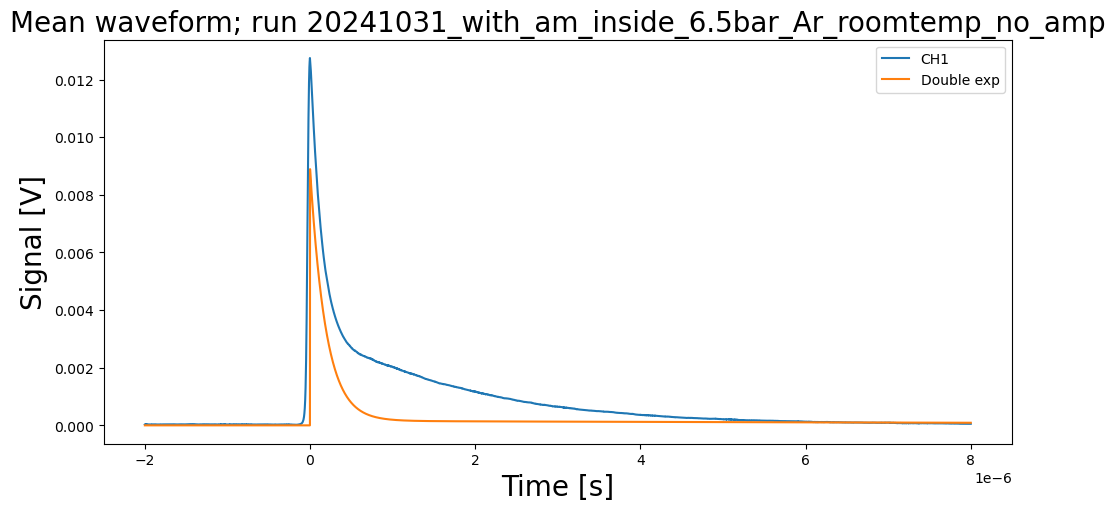

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

time = t[t > 0] # [s]

# fit_function(t, A, t0, rise, tau, tau1, A1, tau2, A2)
initial_guess = [6e-9, 0, 3e-9, 400e-9, 
                 1.9e-07, 8.8e-03, 1.4e-05, 1.6e-04]
# initial_guess = [5e-4, 0, 0.007e-9, 500e-9, 
#                  0.15e-6, 10, 1.4e-6, 40]

ax.plot(t, ch1s, label = f'CH{1}')
# ax.plot(t, ResponseSiPM(t, *initial_guess[:4]), label = f'Sipm response')
ax.plot(t, double_exponential(t, *initial_guess[4:]), label = f'Double exp')
# ax.plot(t, fit_function(t, *initial_guess), '--', label = f'Conv')

title = f'Mean waveform'

ax.set_title(f'{title}; run {run}', fontsize = font_size);
ax.set_xlabel(r'Time [s]', fontsize = font_size);
ax.set_ylabel('Signal [V]', fontsize = font_size);

ax.legend()
# ax.set_xlim(0, 2)

In [16]:
time = t[t > 0] # [s]
wvf = ch1s[t > 0] # [V]
# time = t # [s]
# wvf = ch1s # [V]

# Sample data
waveform_time = time  # Your waveform_time data here
measured_data = wvf  # Your measured data to fit

df_area = np.trapz(x = waveform_time, y = measured_data)

# Initial guesses for the parameters
# fit_function(t, A, t0, rise, tau, tau1, A1, tau2, A2)
initial_guess = [6e-9, 0, 3e-9, 400e-9, 
                 0.15e-6, 0.01, 1.4e-6, 0.004]

# Perform the fit with bounds to keep parameters positive
# bounds = (0, np.inf)  # All parameters must be > 0
bounds = (-np.inf, np.inf)  # All parameters must be > 0

# Perform the fit
params, covariance = curve_fit(double_exponential, waveform_time, measured_data, p0=initial_guess[4:])
# params, covariance = curve_fit(ResponseSiPM, waveform_time, measured_data, p0=initial_guess[:4])
# params, covariance = curve_fit(fit_function, waveform_time, measured_data, p0=initial_guess, bounds = bounds)

# Extract the optimized parameters
opt_tau1, opt_A1, opt_tau2, opt_A2 = params
# opt_A, opt_t0, opt_rise, opt_tau = params
# opt_A, opt_t0, opt_rise, opt_tau, opt_tau1, opt_A1, opt_tau2, opt_A2 = params


In [17]:
params

array([1.29421441e-07, 9.89617548e-03, 1.84316428e-06, 3.38594523e-03])

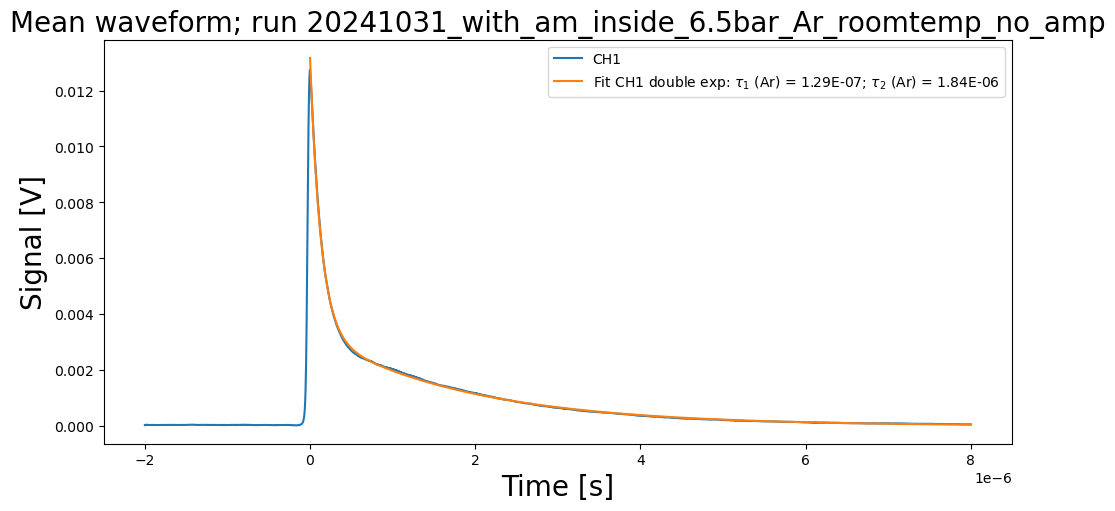

In [18]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

ax.plot(t, ch1s, label = f'CH{1}')
# ax.plot(time, ResponseSiPM(time, *params[:4]), label = fr'Fit CH{1} SiPMs response () ')
ax.plot(time, double_exponential(time, *params[:4]), '-', 
        label = fr'Fit CH{1} double exp: $\tau_1$ (Ar) = {opt_tau1:.2E}; $\tau_2$ (Ar) = {opt_tau2:.2E}')
# ax.plot(t, fit_function(t, *params), 
#         label = fr'$\tau$ (SiPM) = {opt_tau:.2E}; $\tau_1$ (Ar) = {opt_tau1:.2E}; $\tau_2$ (Ar) = {opt_tau2:.2E}')

title = f'Mean waveform'

ax.set_title(f'{title}; run {run}', fontsize = font_size);
ax.set_xlabel(r'Time [s]', fontsize = font_size);
ax.set_ylabel('Signal [V]', fontsize = font_size);

ax.legend()
# ax.set_xlim(0, 2)

###  Decay vs Pressure

In [19]:
time_ticks = 6250

bars    = []
slow = { 'CH1': [], 'CH2': [], 'CH3': [], 'CH4': [] }
fast = { 'CH1': [], 'CH2': [], 'CH3': [], 'CH4': [] }
# Initialize dictionaries to store errors
slow_errors = { 'CH1': [], 'CH2': [], 'CH3': [], 'CH4': [] }
fast_errors = { 'CH1': [], 'CH2': [], 'CH3': [], 'CH4': [] }


for pressure, run in sorted(runs.items()):
    
    bars.append(pressure)
    
    run_path = os.path.join(path, run) 

    # Use glob to find all .h5 files in the directory
    h5_files = glob.glob(f"{run_path}/*.h5")
    h5_files = sorted(h5_files, key=extract_number_h5)
    
    ch1s = []
    ch2s = []
    ch3s = []
    ch4s = []

    for file in h5_files[:3]:

        print(f'Processing... {file}' + ' '*20, end = '\r')

        df = pd.read_hdf(file)

        t    = df["TIME"].to_numpy()[:time_ticks]
        ch1  = df["CH1"].to_numpy().reshape(-1, time_ticks)
#         ch2  = df["CH2"].to_numpy().reshape(-1, time_ticks)
#         ch3  = df["CH3"].to_numpy().reshape(-1, time_ticks)
#         ch4  = df["CH4"].to_numpy().reshape(-1, time_ticks)

        ch1 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch1, t)    
#         ch2 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch2, t)    
#         ch3 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch3, t)    
#         ch4 = np.apply_along_axis(ShiftWaveformToPeak, 1, ch4, t)    

        # Peak correction
#         for ch in [ch1, ch2, ch3, ch4]:
        for ch in [ch1]:
            inf_mask = np.isinf(ch)
            neg_inf_mask = np.isneginf(ch)

            ch[inf_mask] = ch[np.isfinite(ch)].max()
            ch[neg_inf_mask] = ch[np.isfinite(ch)].min()

        ch1_mean = np.average(ch1,axis=0)
#         ch2_mean = np.average(ch2,axis=0)
#         ch3_mean = np.average(ch3,axis=0)
#         ch4_mean = np.average(ch4,axis=0)

        ch1s.append(ch1_mean)
#         ch2s.append(ch2_mean)
#         ch3s.append(ch3_mean)
#         ch4s.append(ch4_mean)


    ch1s = np.average(np.array(ch1s),axis=0)
#     ch2s = np.average(np.array(ch2s),axis=0)
#     ch3s = np.average(np.array(ch3s),axis=0)
#     ch4s = np.average(np.array(ch4s),axis=0)
    
    time = t[t > 0] # [s]
#     for i, ch in enumerate([ch1s, ch2s, ch3s, ch4s]):
    for i, ch in enumerate([ch1s]):
        wvf = ch[t > 0] # [V]

        # Sample data
        waveform_time = time  # Your waveform_time data here
        measured_data = wvf  # Your measured data to fit

        # Initial guesses for the parameters
        # fit_function(t, A, t0, rise, tau, tau1, A1, tau2, A2)
        initial_guess = [6e-9, 0, 3e-9, 400e-9, 
                         0.15e-6, 0.01, 1.4e-6, 0.004]

        # Perform the fit
        params, covariance = curve_fit(double_exponential, waveform_time, measured_data, p0=initial_guess[4:])

        # Extract the optimized parameters
        opt_tau1, opt_A1, opt_tau2, opt_A2 = params# Calculate errors in the parameters
        errors = np.sqrt(np.diag(covariance))
        error_tau1, error_A1, error_tau2, error_A2 = errors

        # Store the values and errors for slow and fast components
        slow[f'CH{i+1}'].append(max(opt_tau1, opt_tau2))
        fast[f'CH{i+1}'].append(min(opt_tau1, opt_tau2))
        
        # Store the errors corresponding to the parameters
        slow_errors[f'CH{i+1}'].append(max(error_tau1, error_tau2))
        fast_errors[f'CH{i+1}'].append(min(error_tau1, error_tau2))
        


In [20]:
channel = 1

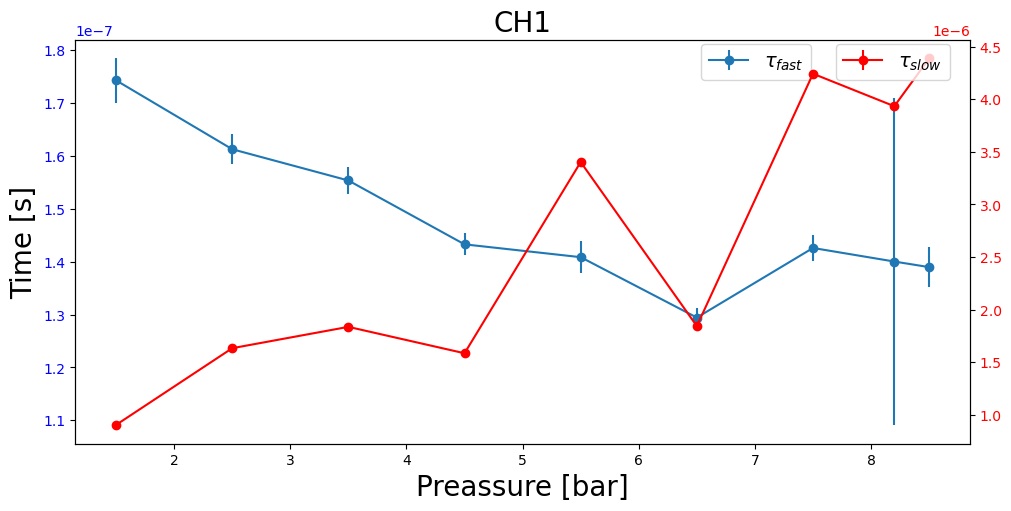

In [21]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(10,5), constrained_layout=True)

font_size = 20

ax.errorbar(bars, fast[f'CH{channel}'], yerr = slow_errors[f'CH{channel}'], fmt='-o', label = r'$\tau_{fast}$')

# Create a second y-axis
ax2 = ax.twinx()
ax2.errorbar(bars, slow[f'CH{channel}'], yerr = slow_errors[f'CH{channel}'], fmt='r-o', label = r'$\tau_{slow}$')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc = (0.85, 0.9), fontsize = 0.7*font_size)

title = f'CH{channel}'

ax.set_title(f'{title}', fontsize = font_size);
ax.set_ylabel(r'Time [s]', fontsize = font_size);
ax.set_xlabel('Preassure [bar]', fontsize = font_size);
ax.tick_params(axis='y', labelcolor='b')

ax.legend(loc = (0.7, 0.9), fontsize = 0.7*font_size)
# ax.set_xlim(0, 2)